In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from lib.constants import AMINO_ACID_MAP, AMINO_ACID_MAP_INV
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [102]:
# trained_on = torch.load('ml_runs/split_kde_old.pt')[0]
# samples = [s for s in Path('ml_samples/kde_v2').iterdir() if s.stem not in trained_on]

In [3]:
def da(target, preds):
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    return np.sqrt(diff(preds[:,0], target[0])**2 + diff(preds[:,1], target[1])**2)

In [105]:
results = []

for sample in samples:
    X, x_res, af, conf, y = torch.load(sample)
    for i in range(X.shape[0]):
        dists = da(y[i], torch.concat([X[i], af[i].unsqueeze(0)]))
        better = dists[:4] < dists[4]
        # not better if w7 is missing
        if (X[i,3] == torch.zeros_like(X[i,3])).all():
            better[3] = False
        results.append((sample.stem, i, better.any().item(), conf[i].item(), *better.tolist()))
results = pd.DataFrame(results, columns=['sample', 'idx', 'kde_better', 'conf', 'w4', 'w5', 'w6', 'w7'])

In [106]:
results.groupby('w7').conf.describe()

,count,mean,std,min,25%,50%,75%,max
w7,,,,,,,,
False,26198.0,94.694171,6.451876,30.69,93.38,97.16,98.50,99.0
True,32917.0,95.008012,6.149143,32.09,93.88,97.31,98.56,99.0


<Axes: >

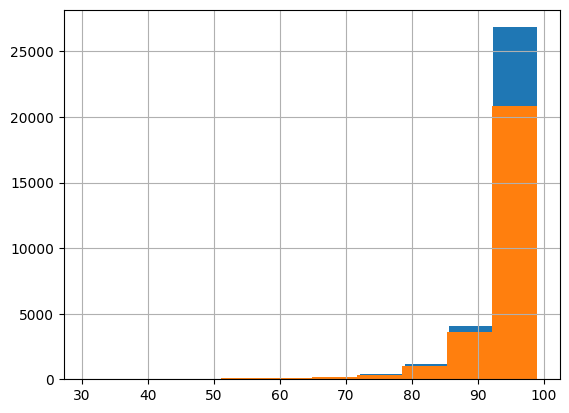

In [107]:
results.loc[results.w7, 'conf'].hist()
results.loc[~results.w7, 'conf'].hist()

# test model on these

In [108]:
from lib.ml.models import MLPredictor

model = MLPredictor([], 'cuda:0', 'ml_runs/best_model-kde_16-32_383.pt')
model.load_weights()

In [109]:
class ProteinDatasetKDE(Dataset):
    def __init__(self, X, xres, af, conf, y):
        self.X, self.xres, self.af, self.conf, self.y = X.float(), xres.float(), af.float(), conf.float(), y.float()
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.conf[i], self.y[i]

In [132]:
results = results.sort_values(['sample', 'idx'])

In [134]:
data = []
results = results.sort_values('sample')
for sample in np.sort(results['sample'].unique()):
    # df = results.loc[(results.w7) & (results['sample'] == sample)]
    df = results.loc[results['sample'] == sample]
    Xi, x_resi, afi, confi, yi = torch.load(f'ml_samples/kde_v2/{sample}.pt')
    idxs = df['idx'].values
    dataset = ProteinDatasetKDE(Xi[idxs], x_resi[idxs], afi[idxs], confi[idxs], yi[idxs])
    data.append(dataset)
dataset = ConcatDataset(data)

In [135]:
data_loader = DataLoader(dataset, batch_size=512, shuffle=False)
preds = []
true = []
afs = []
w7 = []
for X, x_res, af, conf, y in data_loader:
    preds.append(model(X, x_res, af).detach().cpu())
    true.append(y)
    afs.append(af)
    w7.append(X[:,3])
preds = torch.concat(preds)
true = torch.concat(true)
afs = torch.concat(afs)
w7 = torch.concat(w7)

In [137]:
pred_dists = []
af_dists = []
w7_dists = []
for i in range(len(true)):
    pred_dist = da(true[i], preds[i:i+1])
    af_dist = da(true[i], afs[i:i+1])
    w7_dist = da(true[i], w7[i:i+1])
    pred_dists.append(pred_dist)
    af_dists.append(af_dist)
    w7_dists.append(w7_dist)
pred_dists = torch.concat(pred_dists).numpy()
af_dists = torch.concat(af_dists).numpy()
w7_dists = torch.concat(w7_dists).numpy()

In [141]:
results['preds_dist'] = pred_dists
results['af_dist'] = af_dists
results['w7_dist'] = w7_dists

In [147]:
results.iloc[:,-3:].describe()

,preds_dist,af_dist,w7_dist
count,59115.000000,59115.000000,59115.000000
mean,13.618291,15.676891,29.562582
std,22.911182,24.835760,49.380047
min,0.016877,0.037106,0.011790
25%,4.084681,5.382975,3.893985
50%,7.380098,9.301353,7.948206
75%,13.449920,15.878744,21.705034
max,251.881989,250.691498,251.956406


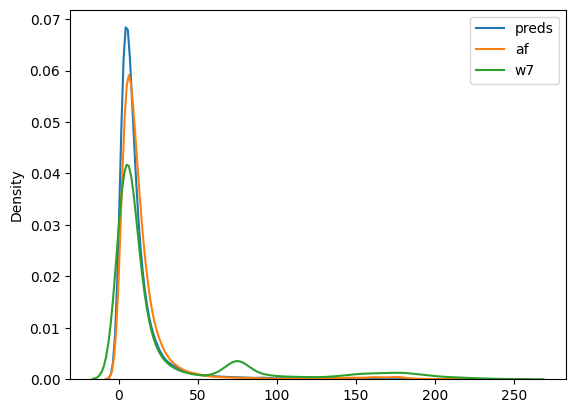

In [149]:
sns.kdeplot(pred_dists, label='preds')
sns.kdeplot(af_dists, label='af')
sns.kdeplot(w7_dists, label='w7')
plt.legend()

In [ ]:
results.to_csv('results_afvskde.csv', index=False)

# Find:
- percent of time model is better than AF
- percent of time w7 is better than AF
- percent of time model is better than w7
- *when w7 is better than af, percent of time model is better than af*
- af conf when af is better vs when w7 or model is better

In [5]:
results = pd.read_csv('results_afvskde.csv')

In [6]:
results

,sample,idx,kde_better,conf,w4,w5,w6,w7,preds_dist,af_dist,w7_dist
0,1B8D,0,True,96.94,False,True,True,True,1.943338,9.151943,4.816625
1,1B8D,101,True,98.19,True,False,False,False,10.470612,10.989541,77.040070
2,1B8D,102,False,98.32,False,False,False,False,9.372042,7.777303,82.229810
3,1B8D,103,False,98.22,False,False,False,False,5.758302,3.945034,88.753990
4,1B8D,104,True,98.24,True,True,True,False,16.886827,15.410114,102.242485
...,...,...,...,...,...,...,...,...,...,...,...
59110,8VY8,25,False,96.16,False,False,False,False,27.743536,1.803237,35.065330
59111,8VY8,26,False,95.73,False,False,False,False,15.646973,8.145999,25.950000
59112,8VY8,27,False,97.45,False,False,False,False,8.995977,8.488922,13.918155
59113,8VY8,14,True,91.42,True,False,False,False,17.029383,10.401259,23.929888


In [157]:
# percent of time model is better than AF
results[results.preds_dist < results.af_dist].shape[0] / results.shape[0]
# 63.1%

0.6312949336039922

In [159]:
# percent of times w7 is better than AF
results[results.w7_dist < results.af_dist].shape[0] / results.shape[0]
# 55.9%

0.5594688319377484

In [161]:
# percent of times model is better than w7
results[results.preds_dist < results.w7_dist].shape[0] / results.shape[0]
# 55.6%

0.5561532605937579

In [164]:
# when w7 better than af, percent of times model is better than af
results[(results.w7) & (results.preds_dist < results.af_dist)].shape[0] / results[results.w7].shape[0]
# 92.2%

0.9216818057538658

In [170]:
# conf when af is better
results[~results.w7].conf.describe()
# average 94.7%

count    26198.000000
mean        94.694171
std          6.451876
min         30.690000
25%         93.380000
50%         97.160000
75%         98.500000
max         99.000000
Name: conf, dtype: float64

In [169]:
# Conf of af when w7 is better
results[results.w7].conf.describe()
# average 95.0

count    32917.000000
mean        95.008012
std          6.149143
min         32.090000
25%         93.880000
50%         97.310000
75%         98.560000
max         99.000000
Name: conf, dtype: float64

In [171]:
# conf when model is better
results[results.preds_dist < results.af_dist].conf.describe()
# average 94.89%

count    37319.000000
mean        94.890586
std          6.297795
min         32.090000
25%         93.730000
50%         97.250000
75%         98.550000
max         99.000000
Name: conf, dtype: float64